## Tutorial-04 Intro to Frenet Optimal Planner

**Step 1** 从文件中读取全局路径

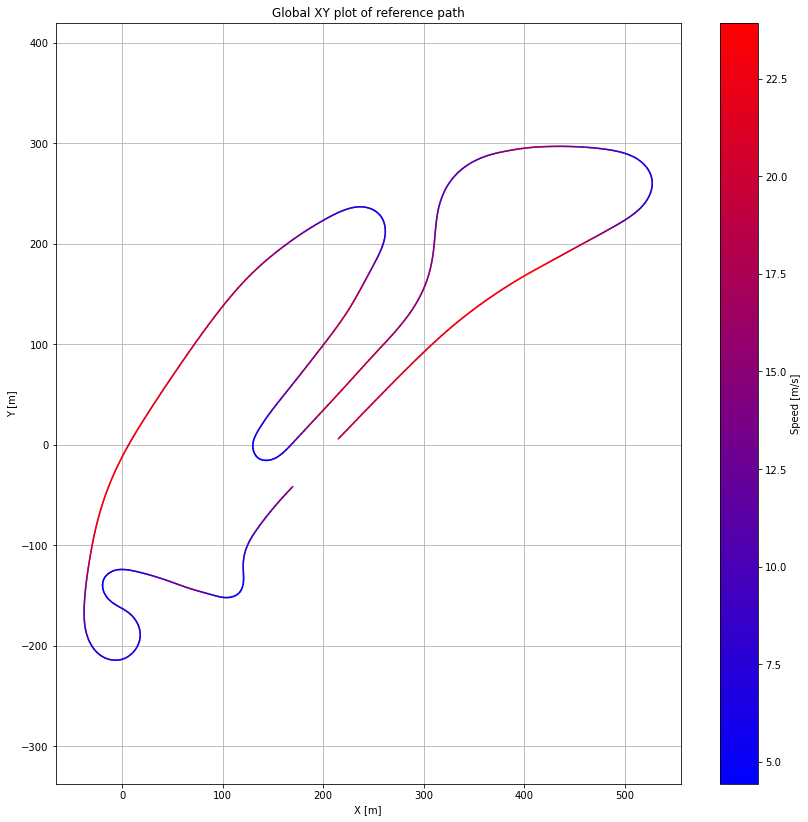

In [134]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# 通过 numpy 的 genfromtxt 读取 csv 文件，并跳过第一行
trajectory_data = np.genfromtxt('./data/global_trajectory.csv', delimiter=';', skip_header=1)

# 为了避免行向量和列向量混淆导致的错误，尽可能使用 np.mat 而非 np.array 来进行数组操作
# 所以这里将读取的数据转换为了 np.mat 的格式
reference_trajectory = np.mat(trajectory_data)

# 将数组分割，方便后续操作
reference_s     = reference_trajectory[:, 0]             # [m]
reference_x     = reference_trajectory[:, 1]             # [m]
reference_y     = reference_trajectory[:, 2]             # [m]
reference_theta = reference_trajectory[:, 3] + math.pi/2 # [rad]
reference_v     = reference_trajectory[:, 5] * 0.44704   # [m/s]

# 使用 pyplot 的 Normalize 函数，将车速的最小值和最大值进行归一化处理
# 使其值位于 0-1 之间
norm = plt.Normalize(reference_v.min(), reference_v.max())

# 定义一个字典，用于描述色彩映射的过程。在这个字典中，键是颜色通道（'red', 'green', 'blue'），值是一个元组列表。
# 每个元组表示一个颜色通道在色彩映射中的变化过程，元组的第一个元素是颜色通道的位置（从 0 到 1），第二个和第三个元素是该位置的颜色值（也是从0到1）。
# 在此例中，我们定义了一个从蓝色过渡到红色的色彩映射。
cdict = {'red':   ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)), 
         'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)), 
         'blue':  ((0.0, 1.0, 1.0), (1.0, 0.0, 0.0))} 

# 使用定义好的颜色字典创建线性分段色彩映射，映射的名称为 'Bl_Rd'，分段数为 256
c_m = LinearSegmentedColormap('Rd_Bl', cdict, 256)

# 创建一个新的图窗，并设置其尺寸为 8x8
fig, ax = plt.subplots(figsize=(14, 14))

# 遍历参考路径中的每个点，根据车速来选取颜色，并绘制对应的路径
for i in range(1, len(reference_x)):
    x_segment = np.array(reference_x[i-1:i+1]).ravel()
    y_segment = np.array(reference_y[i-1:i+1]).ravel()
    c_segment = c_m(norm(np.array(reference_v[i-1:i+1]).ravel()))
    ax.plot(x_segment, y_segment, color=c_segment[0])

# 在右边放置一个 colorbar
colorbar = cm.ScalarMappable(cmap=c_m, norm=norm)
colorbar.set_array([])
fig.colorbar(colorbar, label='Speed [m/s]')

plt.figure(1, figsize=(10, 10))
plt.grid(True)
plt.title('Global XY plot of reference path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')

plt.show()

**Step 2** 根据全局路创建 Frenet 参考系

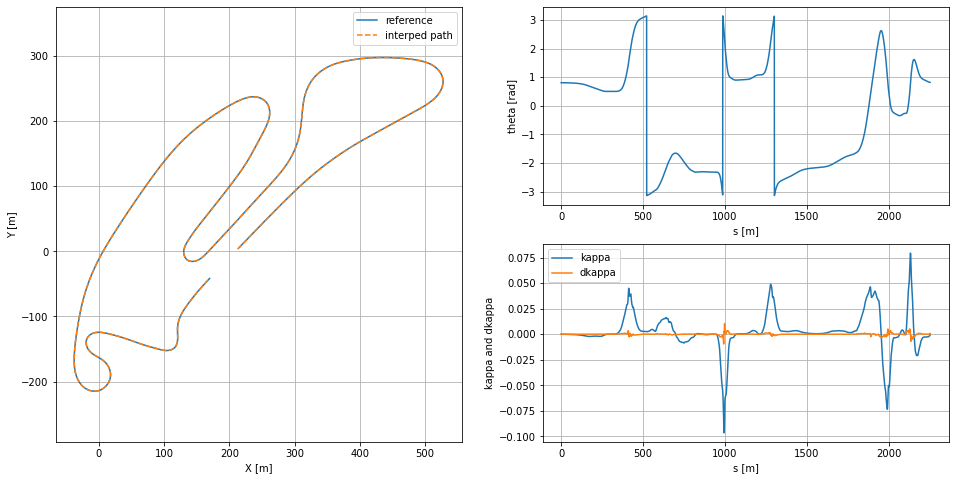

In [135]:
import copy
from scipy.interpolate import BSpline
import lib.utils as utils
from scipy.spatial import cKDTree

'''
创建一个 ReferencePath 类来帮助 Local Planner 完成 frenet-cartesian 之间的坐标转换
'''
class ReferencePath:
    def __init__(
        self,
        # waypoint_s: np.mat, # 参考路径点的累计弧长
        waypoint_x: np.mat, # 参考路径点的 x 坐标
        waypoint_y: np.mat, # 参考路径点的 y 坐标
        resolution: float
        ):       
        
        waypoint_s = np.zeros_like(waypoint_x)
        for i in range(1, len(waypoint_x)):
            prev_x, prev_y = waypoint_x[i - 1], waypoint_y[i - 1]
            curr_x, curr_y = waypoint_x[i], waypoint_y[i]
            waypoint_s[i] = waypoint_s[i - 1] + np.sqrt((curr_x - prev_x) ** 2 + (curr_y - prev_y) ** 2)
        
        if len(waypoint_s) < 2:
            print('waypoints_s: ', waypoint_s)
            raise ValueError("Waypoint size less than 2")
        
        # 记录路径基本信息
        self.total_length_ = waypoint_s[-1, 0]
        
        # 使用三次样条曲线拟合
        spline_x = BSpline(np.ravel(waypoint_s), np.ravel(waypoint_x), 3)
        spline_y = BSpline(np.ravel(waypoint_s), np.ravel(waypoint_y), 3)
        
        # 初始化参考路径的分辨率
        self.sample_resolution_ = resolution
        self.interp_size_ = (np.ceil(self.total_length_ / self.sample_resolution_) + 1).astype(int)
        
        self.interp_s_ = np.linspace(0, self.total_length_, self.interp_size_)
        
        # 计算插值后的 x y theta kappa dkappa
        self.interp_x_      = np.mat(spline_x(self.interp_s_)).T
        self.interp_y_      = np.mat(spline_y(self.interp_s_)).T
        
        self.interp_theta_  = self.calculate_theta() 
        self.interp_kappa_  = self.calculate_kappa()
        self.interp_dkappa_ = self.calculate_dkappa()

        interp_xy_stack = np.hstack((self.interp_x_, self.interp_y_)) 
        self.kd_tree_ = cKDTree(interp_xy_stack)
        
    def calculate_theta(self):
        # 初始化航向角为空列表
        interp_theta = np.zeros((self.interp_size_, 1))
        
        # 如果路径点数量为 2，则无法使用中心差分
        if self.interp_size_ == 2:
            dy = self.interp_y_[1, 0] - self.interp_y_[1, 0]
            dx = self.interp_x_[1, 0] - self.interp_x_[0, 0]
            theta = np.arctan2(dy, dx)
            
            interp_theta[0, 0] = theta
            interp_theta[1, 0] = theta
            
            return np.mat(interp_theta)
        
        # 使用中心差分方法计算航向角        
        for i in range(1, self.interp_size_-1):
            dy = self.interp_y_[i + 1, 0] - self.interp_y_[i - 1, 0]
            dx = self.interp_x_[i + 1, 0] - self.interp_x_[i - 1, 0]    
            interp_theta[i, 0] = np.arctan2(dy, dx)
        
        # 补全两头的航向信息
        interp_theta[ 0, 0] = copy.deepcopy(interp_theta[ 1, 0])
        interp_theta[-1, 0] = copy.deepcopy(interp_theta[-2, 0])
        
        return np.mat(interp_theta)
    
    def calculate_kappa(self):
        # 初始化所有曲率为 0
        interp_kappa = np.zeros((self.interp_size_, 1))
        
        # 使用中心差分法计算曲率
        for i in range(1, self.interp_size_ - 1):
            dtheta = utils.normalize_angle(self.interp_theta_[i + 1, 0] - self.interp_theta_[i - 1, 0])
            ds = self.interp_s_[i + 1] - self.interp_s_[i - 1]
            interp_kappa[i, 0] = dtheta / ds
        
        # 补全两头的航向信息    
        interp_kappa[ 0, 0] = copy.deepcopy(interp_kappa[ 1, 0])
        interp_kappa[-1, 0] = copy.deepcopy(interp_kappa[-2, 0])

        return np.mat(interp_kappa)

    def calculate_dkappa(self):
        # 初始化曲率变化率为 0
        interp_dkappa = np.zeros((self.interp_size_, 1))
        
        # 使用中心差分法计算曲率
        for i in range(1, self.interp_size_ - 1):
            dkappa = self.interp_kappa_[i + 1, 0] - self.interp_kappa_[i - 1, 0]
            ds = self.interp_s_[i + 1] - self.interp_s_[i - 1]
            interp_dkappa[i, 0] = dkappa / ds

        # 补全两头的曲率变化率信息
        interp_dkappa[0, 0]  = copy.deepcopy(interp_dkappa[1, 0])
        interp_dkappa[-1, 0] = copy.deepcopy(interp_dkappa[-2, 0])

        return np.mat(interp_dkappa)
    
ref_path = ReferencePath(reference_x, reference_y, 0.5)

plt.figure(2, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(reference_x, reference_y, label='reference')
plt.plot(ref_path.interp_x_, ref_path.interp_y_, linestyle='dashed', label='interped path')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')
plt.grid(True)
plt.box(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ref_path.interp_s_, ref_path.interp_theta_)
plt.xlabel('s [m]')
plt.ylabel('theta [rad]')
plt.axis('tight')
plt.grid(True)
plt.box(True)

plt.subplot(2, 2, 4)
plt.plot(ref_path.interp_s_, ref_path.interp_kappa_, label='kappa')
plt.plot(ref_path.interp_s_, ref_path.interp_dkappa_, label='dkappa')
plt.xlabel('s [m]')
plt.ylabel('kappa and dkappa')
plt.axis('tight')
plt.grid(True)
plt.box(True)
plt.legend()

plt.show()


**Step 3** 测试 Frenet 坐标系下的五次多项式横 / 纵向采样

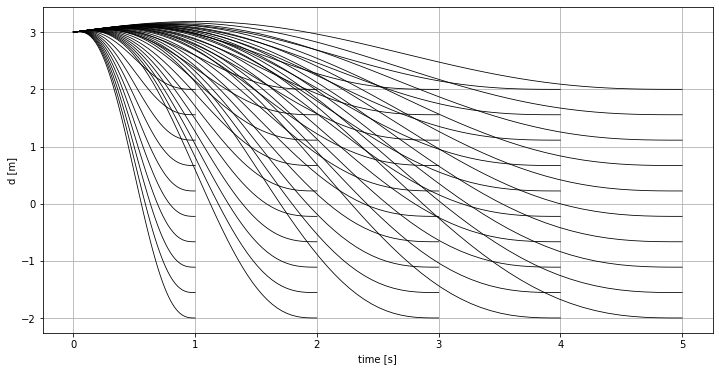

In [136]:
import lib.frenet_optimal_planner as poly

# 测试五次多项式采样
# 初始的横向状态
initial_d      = 3   # 初始的横向位移
initial_d_dot  = 0.3 # 初始的横向速度
initial_d_ddot = 0   # 初始的横向加速度
initial_time   = 0   # 采样的起始时间

# 终止的侧向状态
terminal_d_list = np.linspace(-2, 2, 10) # 采样的目标侧向位移
terminal_d_dot  = 0                     # 采样的终止侧向速度
terminal_d_ddot = 0                     # 采样点终止侧向加速度
terminal_time_list   = [1, 2, 3, 4, 5]  # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 6))
for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_d in terminal_d_list:
        lateral_trajectory = poly.QuinticPolynomial(
            initial_d , initial_d_dot , initial_d_ddot , 
            terminal_d, terminal_d_dot, terminal_d_ddot, 
            sample_time
        )
        
        plt.plot(sample_time, np.ravel(lateral_trajectory.p_), color='black', linewidth=0.8)
        
plt.grid(True)
plt.axis('tight')
plt.xlabel('time [s]')
plt.ylabel('d [m]')
plt.show()

**Step 4** 测试 Frenet 坐标系下四次多项式的纵向采样

Text(0, 0.5, 's_dot [m/s]')

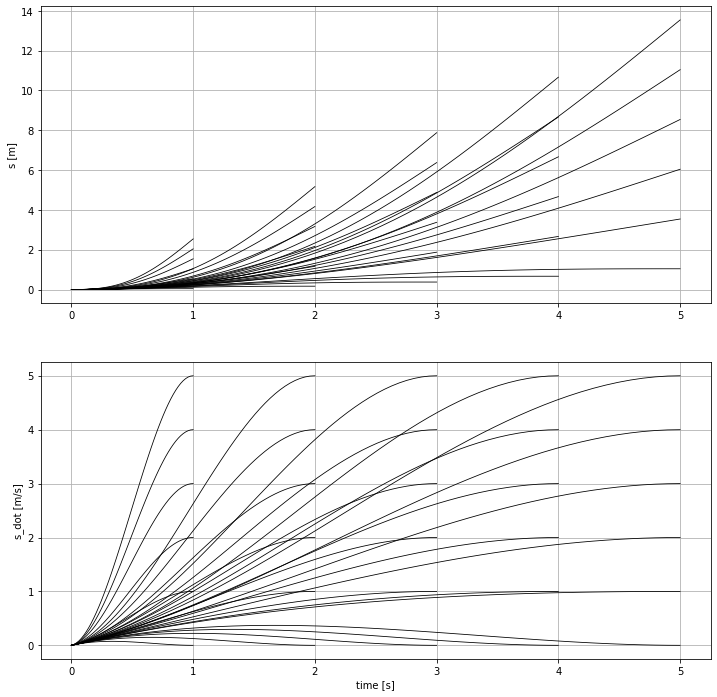

In [137]:
# 测试五次多项式采样
# 初始的横向状态
initial_s      =  0   # 起点累计弧长
initial_s_dot  =  0.0 # 初始纵向速度
initial_s_ddot =  0.5 # 初始的纵向加速度
initial_time   =  0   # 采样的起始时间

# 终止的侧向状态
terminal_s_dot_list = np.linspace(0, 5, 6) # 采样的目标车速
terminal_s_ddot  = 0                       # 采样的目标加速度
terminal_time_list   = [1, 2, 3, 4, 5]     # 采样的终止时间

# 采样点的个数
sample_num = 50

plt.figure(3, figsize=(12, 12))
ax_s     = plt.subplot(2, 1, 1)
ax_s_dot = plt.subplot(2, 1, 2)

for terminal_time in terminal_time_list:
    sample_time = np.linspace(initial_time, terminal_time, sample_num)
    
    for terminal_s_dot in terminal_s_dot_list:
        longitudinal_trajectory = poly.QuarticPolinomial(
            initial_s     , initial_s_dot  , initial_s_ddot, 
            terminal_s_dot, terminal_s_ddot, sample_time
        )
        
        ax_s.plot(sample_time, np.ravel(longitudinal_trajectory.p_), color='black', linewidth=0.8)
        ax_s_dot.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_), color='black', linewidth=0.8)
        
ax_s.grid(True)
ax_s_dot.grid(True)
ax_s.set_ylabel('s [m]')
ax_s_dot.set_xlabel('time [s]')
ax_s_dot.set_ylabel('s_dot [m/s]')

**Step 6** 创建 Frenet Optimal Planner 局部规划器

c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract


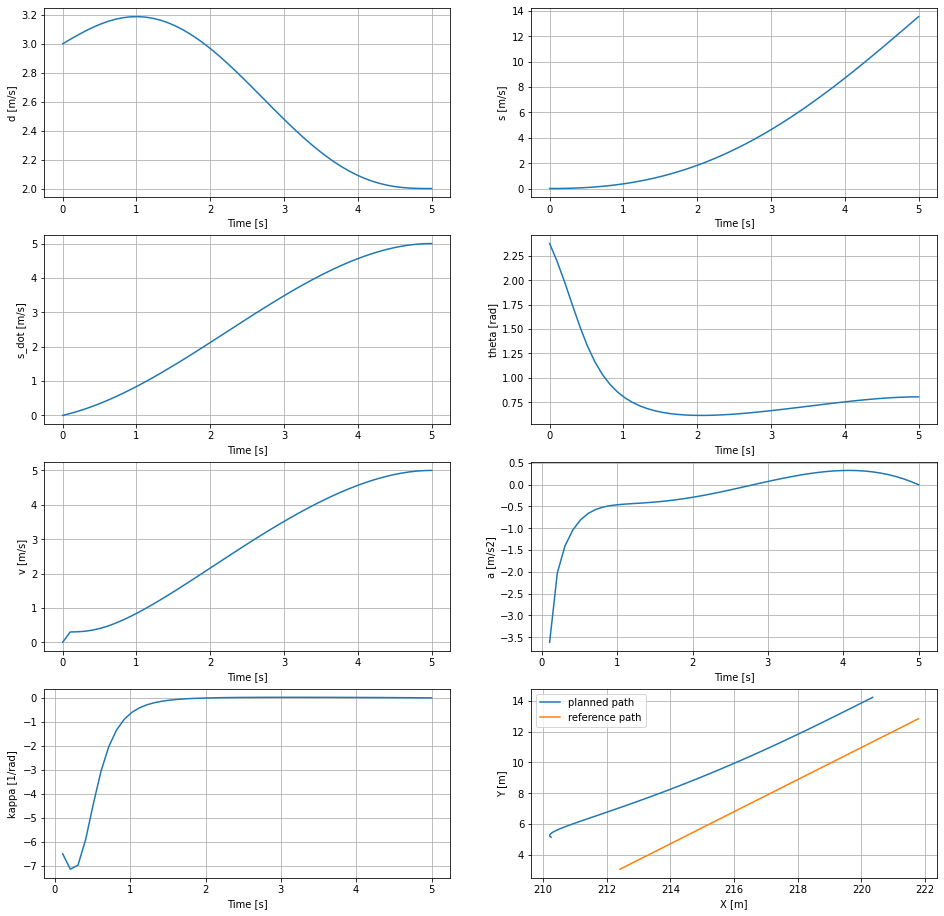

In [138]:
import lib.utils

class Trajectory:
    def __init__(
        self,
        longitudinal_curve: poly.QuarticPolinomial,
        lateral_curve: poly.QuinticPolynomial,
        t_array: np.array,
        reference_path: ReferencePath
        ):
        
        self.sample_time_ = t_array

        self.s_      = longitudinal_curve.p_
        self.s_dot_  = longitudinal_curve.p_dot_
        self.s_ddot_ = longitudinal_curve.p_ddot_
        self.s_dddot_ = longitudinal_curve.p_dddot_

        self.d_       = lateral_curve.p_
        self.d_dot_   = lateral_curve.p_dot_
        self.d_ddot_  = lateral_curve.p_ddot_
        self.d_dddot_ = lateral_curve.p_dddot_

        # 计算横 / 纵向轨迹的 Jerk 代价
        self.lateral_jerk_      = np.trapz(np.ravel(self.d_dddot_) ** 2, self.sample_time_)
        self.longitudinal_jerk_ = np.trapz(np.ravel(self.s_dddot_) ** 2, self.sample_time_)
        
        self.frenet_to_cartesian(reference_path)
    
    def frenet_to_cartesian(self, reference_path: ReferencePath):
        x_ref      = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_x_))
        y_ref      = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_y_))
        theta_ref  = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_theta_))
        kappa_ref  = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_kappa_))
        dkappa_ref = np.interp(self.s_, np.ravel(reference_path.interp_s_), np.ravel(reference_path.interp_dkappa_))
        
        self.x_ref_      = np.mat(x_ref)
        self.y_ref_      = np.mat(y_ref)
        self.theta_ref_  = np.mat(theta_ref)
        self.kappa_ref_  = np.mat(kappa_ref)
        self.dkappa_ref_ = np.mat(dkappa_ref)
        
        cartesian_x = np.ravel(self.x_ref_) - np.ravel(self.d_) * np.sin(np.ravel(self.theta_ref_))
        cartesian_y = np.ravel(self.y_ref_) + np.ravel(self.d_) * np.cos(np.ravel(self.theta_ref_))
        
        self.x_ = np.mat(cartesian_x).T
        self.y_ = np.mat(cartesian_y).T
    
        # 计算 d(s) 的一阶导
        d_prime = np.ravel(self.d_dot_) / np.ravel(self.s_dot_)

        # 计算 d(s) 的二阶导       
        d_pprime = (np.ravel(self.d_ddot_) - d_prime * np.ravel(self.s_ddot_)) / (np.ravel(self.s_dot_) ** 2)

        # 计算航向角增量
        delta_theta = np.arctan2(d_prime, (1 - np.ravel(kappa_ref) * np.ravel(self.d_)))
        
        # 计算航向角
        theta = np.ravel(theta_ref) + delta_theta
        self.theta_ = np.mat(theta).T
        
        # 计算车速
        v = np.ravel(self.s_dot_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta)
        self.v_ = np.mat(v).T
        
        # 计算曲率
        kappa = (((d_pprime + (np.ravel(dkappa_ref) * np.ravel(self.d_) + np.ravel(kappa_ref) * d_prime) * np.tan(delta_theta))
            * (np.cos(delta_theta) ** 2) / (1 - np.ravel(kappa_ref) * np.ravel(self.d_))
            + np.ravel(kappa_ref)
        ) * np.cos(delta_theta) / (1 - np.ravel(kappa_ref) * np.ravel(self.d_)))    
        
        self.kappa_ = np.mat(kappa).T
        
        # 计算加速度
        a = np.ravel(self.d_ddot_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta) + (
            np.ravel(self.s_dot_) ** 2
        ) / np.cos(delta_theta) * (
            (1 - np.ravel(kappa_ref) * np.ravel(self.d_))
            * np.tan(delta_theta)
            * (
                np.ravel(self.kappa_) * (1 - np.ravel(kappa_ref) * np.ravel(self.d_)) / np.cos(delta_theta)
                - np.ravel(kappa_ref)
            )
            - (np.ravel(dkappa_ref) * np.ravel(self.d_) + np.ravel(dkappa_ref) * d_prime)
        )
        
        self.a_ = np.mat(a).T
        return
    
cartesian_trajectory = Trajectory(longitudinal_trajectory, lateral_trajectory, sample_time, ref_path)
area = 30

plt.figure(4, figsize=(16, 16))
plt.subplot(4, 2, 1)
plt.plot(sample_time, np.ravel(lateral_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('d [m/s]')

plt.subplot(4, 2, 2)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s [m/s]')

plt.subplot(4, 2, 3)
plt.plot(sample_time, np.ravel(longitudinal_trajectory.p_dot_))
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('s_dot [m/s]')

plt.subplot(4, 2, 4)
plt.plot(sample_time, cartesian_trajectory.theta_ )
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('theta [rad]')

plt.subplot(4, 2, 5)
plt.plot(sample_time, cartesian_trajectory.v_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('v [m/s]')

plt.subplot(4, 2, 6)
plt.plot(sample_time, cartesian_trajectory.a_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('a [m/s2]')

plt.subplot(4, 2, 7)
plt.plot(sample_time, cartesian_trajectory.kappa_)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('kappa [1/rad]')

plt.subplot(4, 2, 8)
plt.plot(cartesian_trajectory.x_, cartesian_trajectory.y_, label='planned path')
plt.plot(cartesian_trajectory.x_ref_, cartesian_trajectory.y_ref_, label='reference path')
plt.grid(True)
plt.legend()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

plt.show()

**Step 7** 建立一个碰撞检测器用于筛选发生碰撞的路径

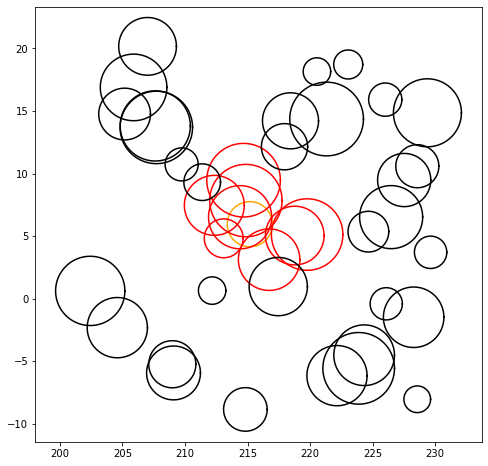

In [139]:
import lib.data_struct as struct

class VehicleGeometry:
    # rl ------------- fl
    #    |           |
    #    |           |
    # rr ------------ fr
    def __init__(self, l, w):
        self.l_ = l
        self.w_ = w
        
        self.corner_fl_ = [ l/2,  w/2]
        self.corner_fr_ = [ l/2, -w/2]
        self.corner_rl_ = [-l/2,  w/2]
        self.corner_rr_ = [-l/2, -w/2]
        
        self.radius_ = math.sqrt((l/2)**2 + (w/2)**2)

    def check_collision_free(self, ego_x, ego_y, obstacle_state: struct.StaticObstacle):
        obs_x = obstacle_state.pose_.x_
        obs_y = obstacle_state.pose_.y_
        
        dist  = utils.distance(ego_x, ego_y, obs_x, obs_y)
        
        # 如果车和障碍物之间的距离大于碰撞半径，则说明无碰撞
        if dist > self.radius_ + obstacle_state.radius_:
            return True
        else:
            return False
        
    def get_vehicle_shape(self, vehicle_pose: struct.Transform):
        ego_x     = vehicle_pose.x_
        ego_y     = vehicle_pose.y_
        ego_theta = vehicle_pose.theta_

        rotation_matrix = np.mat([[ math.cos(ego_theta),   math.sin(ego_theta)], 
                                  [-math.sin(ego_theta),  math.cos(ego_theta)]])

        original_bound = np.mat([self.corner_fl_, 
                                 self.corner_fr_, 
                                 self.corner_rr_, 
                                 self.corner_rl_, 
                                 self.corner_fl_])
        
        # Then, apply the rotation
        rotated_bound = original_bound * rotation_matrix

        rotated_bound[:, 0] += ego_x
        rotated_bound[:, 1] += ego_y

        return rotated_bound

################################################################################################################################

def plot_circle(center_x, center_y, radius, circle_color):
    theta = np.linspace(0, 2*math.pi, 100)
    x = radius * np.cos(theta) + center_x
    y = radius * np.sin(theta) + center_y
    
    plt.plot(x, y, color=circle_color)
    
    return

################################################################################################################################
    
# 初始化车辆位置和碰撞检测器
initial_pose = struct.Transform(reference_x[0, 0], 
                                reference_y[0, 0], 
                                reference_theta[0, 0])

initial_state = struct.State(initial_pose, v=0, a=0, kappa=0)

vehicle_geometry = VehicleGeometry(l=3, w=2)

# 生成测试场景
obs_num = 40
obs_x_list      = initial_pose.x_ + np.random.uniform(-15, 15, obs_num)
obs_y_list      = initial_pose.y_ + np.random.uniform(-15, 15, obs_num)
obs_radius_list = np.random.uniform(1, 3, obs_num)

# 创建一个新的图形和坐标轴
plt.figure(5, figsize=(8, 8))

plot_circle(initial_pose.x_, 
            initial_pose.y_, 
            vehicle_geometry.radius_, 
            'orange')

# 以 obs_x, obs_y 为圆心，obs radius 为半径画黑色的圆形
for x, y, radius in zip(obs_x_list, obs_y_list, obs_radius_list):
    obs_pose = struct.Transform(x, y, 0)
    obs_state = struct.StaticObstacle(obs_pose, radius)
    
    if vehicle_geometry.check_collision_free(initial_state.pose_.x_, initial_state.pose_.y_, obs_state):
        plot_circle(x, y, radius, 'black')
    else:
        plot_circle(x, y, radius, 'red')
    
    
plt.axis('equal')    
plt.show()  # 显示图形

**Step 8** 集成上述功能，实现完整的局部轨迹规划

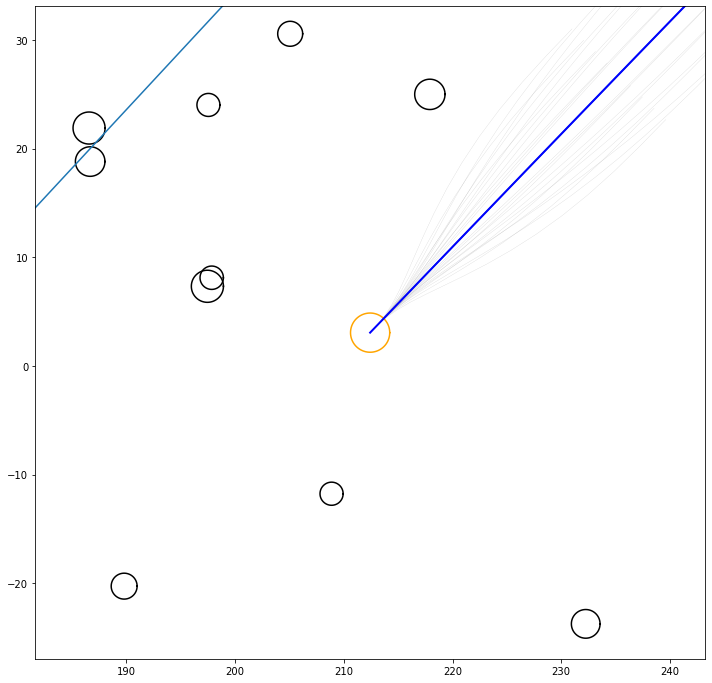

In [140]:
from typing import List, Tuple

class FrenetOptimalPlanner:
    def __init__(self, reference_path: ReferencePath):
        self.min_terminal_t_ = 3 # 最小采样终止时间
        self.max_terminal_t_ = 5 # 最大采样终止时间
        self.num_terminal_t_ = 3 # 采样终止时间的个数
        self.num_sample_t_   = 8 # 采样时间离散的数量
        self.sample_step_    = 0.2 # 采样步长
        
        self.min_terminal_v_ = 17  # 最小减速到 0
        self.max_terminal_v_ = 17 # 最快加速到 17 m/s
        self.num_terminal_v_ = 1  # 速度采样的个数
        
        self.min_terminal_d_ = -6 # 左侧最大偏移量
        self.max_terminal_d_ =  6 # 右侧最大偏移量
        self.num_terminal_d_ =  9 # 横向采样个数 
        
        self.lateral_jerk_coeff_    = 1   # 侧向加速度变化代价
        self.lateral_time_coeff_    = 0.1 # 换道时间代价
        self.lateral_deviate_coeff_ = 5   # 与参考线偏差代价
        
        self.longitudinal_jerk_coeff_ = 1     # 纵向加速度变化代价
        self.longitudinal_time_coeff_ = 0.1   # 加/减速时间代价
        self.longitudinal_deviate_coeff_ = 10 # 与目标车速偏差代价
        
        self.lateral_cost_coeff_ = 1          # 横向代价
        self.longitudinal_cost_coeff_ = 5     # 纵向代价
        
        self.target_v_ = self.max_terminal_v_ # 目标车速
        
        self.kappa_limit_ = 1.0 # 曲率限制
        self.a_limit_     = 10  # 加速度限制
        self.v_limit_     = 20  # 速度限制
        
        # 碰撞检测距离阈值
        self.obs_check_thresh_ = self.v_limit_ * self.max_terminal_t_
        
        self.reference_path_ = reference_path
        
    def generate_trajectory_sample(self, frenet_state: struct.FrenetState) -> List[Trajectory]:
        longitudinal_sample_list  = []
        lateral_sample_list       = []
        cartesian_trajectory_list = []
        
        terminal_s_ddot = 0
        terminal_d_dot  = 0
        terminal_d_ddot = 0
        
        # 生成采样轨迹
        for terminal_t in np.linspace(self.min_terminal_t_, 
                                      self.max_terminal_t_, 
                                      self.num_terminal_t_):
            # sample_time = np.linspace(0, terminal_t, self.num_sample_t_)
            sample_time = np.arange(0, terminal_t + self.sample_step_, self.sample_step_)
            for terminal_s_dot in np.linspace(self.min_terminal_v_, 
                                              self.max_terminal_v_, 
                                              self.num_terminal_v_):
                # 如果始末都没速度，则跳过
                if frenet_state.s_dot_ == 0 and terminal_s_dot == 0:
                    continue
                
                longitudinal_sample = poly.QuarticPolinomial(
                    frenet_state.s_, frenet_state.s_dot_, frenet_state.s_ddot_,
                    terminal_s_dot , terminal_s_ddot    , sample_time)
                
                longitudinal_sample_list.append(longitudinal_sample)
                
                for terminal_d in np.linspace(self.min_terminal_d_, 
                                              self.max_terminal_d_, 
                                              self.num_terminal_d_):    
                    lateral_sample = poly.QuinticPolynomial(
                        frenet_state.d_, frenet_state.d_dot_, frenet_state.d_ddot_, 
                        terminal_d     , terminal_d_dot     , terminal_d_ddot, 
                        sample_time
                    )
                    
                    lateral_sample_list.append(lateral_sample)
                    
                    # 将横、纵向采样结果耦合，得到 Cartesian 坐标系下的轨迹
                    cartesian_trajectory = Trajectory(longitudinal_sample, 
                                                      lateral_sample, 
                                                      sample_time, 
                                                      self.reference_path_)
                    
                    cartesian_trajectory_list.append(cartesian_trajectory)
                            
        return cartesian_trajectory_list
                        
    def choose_optimal_trajectory(self, 
                                  cartesian_trajectory_list: list, 
                                  vehicle_geometry: VehicleGeometry, 
                                  obs_list: list) -> Tuple[Trajectory, List[Trajectory]]:
        valid_trajectory = []
        trajectory_cost_list = []
        
        for cartesian_trajectory in cartesian_trajectory_list:
            # max_kappa = np.amax(cartesian_trajectory.kappa_)
            # max_a = np.amax(cartesian_trajectory.a_)
            # max_v = np.amax(cartesian_trajectory.v_) 
            min_v = np.amin(cartesian_trajectory.v_)
            # max_d_dot = np.amax(cartesian_trajectory.d_dot_)
            
            # # 检查硬约束
            # if abs(max_kappa) > self.kappa_limit_ or max_a > self.a_limit_ or max_v > self.v_limit_ or min_v < 0:
            #     continue    
            if min_v < 0:
                continue      
            
            # 检查碰撞约束
            collision_flag = 0
            for i in range(len(obs_list)):
                obs = obs_list[i]
                
                # 判断障碍物与自车的距离，如果距离比较远，则不进行碰撞检测
                obs_dist = utils.distance(obs.pose_.x_, obs.pose_.y_,
                                      cartesian_trajectory.x_[0, 0], 
                                      cartesian_trajectory.y_[0, 0])
                if obs_dist > self.obs_check_thresh_:
                    continue
                
                # 判断障碍物与自车在参考线上的距离差，如果距离比较短，则不进行碰撞检测
                _, obs_idx = self.reference_path_.kd_tree_.query([obs.pose_.x_, obs.pose_.y_])
                obs_s = self.reference_path_.interp_s_[obs_idx]
                if obs_s - cartesian_trajectory.s_[0] > self.obs_check_thresh_ or obs_s < cartesian_trajectory.s_[0]:
                    continue
                
                for j in range(len(cartesian_trajectory.s_)):
                    if not vehicle_geometry.check_collision_free(cartesian_trajectory.x_[j], 
                                                                 cartesian_trajectory.y_[j],
                                                                 obs):
                        collision_flag = 1
            
            if collision_flag:
                continue
                
            lateral_cost = (
                self.lateral_jerk_coeff_    * cartesian_trajectory.lateral_jerk_ + 
                self.lateral_time_coeff_    * cartesian_trajectory.sample_time_[-1] +
                self.lateral_deviate_coeff_ * cartesian_trajectory.d_[-1, 0] ** 2
                )
            
            longitudinal_cost = (
                self.longitudinal_jerk_coeff_ * cartesian_trajectory.longitudinal_jerk_ + 
                self.longitudinal_time_coeff_ * cartesian_trajectory.sample_time_[-1] + 
                self.longitudinal_deviate_coeff_  * (cartesian_trajectory.v_[-1, 0] - self.target_v_)**2
            )
            
            total_cost = (self.lateral_cost_coeff_ * lateral_cost 
                            + self.longitudinal_cost_coeff_ * longitudinal_cost)
            
            if math.isnan(total_cost):
                continue
            
            valid_trajectory.append(cartesian_trajectory)
            trajectory_cost_list.append(total_cost)
    
        if valid_trajectory:
            optimal_trajectory_cost = min(trajectory_cost_list)
            optimal_trajectory_index = trajectory_cost_list.index(optimal_trajectory_cost)
            optimal_trajectory = valid_trajectory[optimal_trajectory_index]
        else:
            optimal_trajectory = math.nan
        
        return optimal_trajectory, valid_trajectory
    
    def update_planning(self, 
                        frenet_state: struct.FrenetState, 
                        vehicle_geometry: VehicleGeometry, 
                        obs_list: list) -> Tuple[Trajectory, List[Trajectory], List[Trajectory]]:
        trajectory_list = self.generate_trajectory_sample(frenet_state)
        optimal_trajectory, valid_trajectory = self.choose_optimal_trajectory(trajectory_list, vehicle_geometry, obs_list)
        
        return optimal_trajectory, valid_trajectory, trajectory_list

################################################################################################################################

plt.figure(6, figsize=(12, 12))
plt.axis('equal')
            
# 初始化车辆位置和碰撞检测器
initial_pose = struct.Transform(ref_path.interp_x_[0, 0], 
                                ref_path.interp_y_[0, 0], 
                                ref_path.interp_theta_[0, 0])

initial_state = struct.State(initial_pose, v=0, a=0, kappa=0)
vehicle_geometry = VehicleGeometry(l=3, w=2)

plot_circle(initial_pose.x_, 
            initial_pose.y_, 
            vehicle_geometry.radius_, 
            'orange')

# 生成测试场景
obs_num = 10
obs_x_list      = initial_pose.x_ + np.random.uniform(-30, 30, obs_num)
obs_y_list      = initial_pose.y_ + np.random.uniform(-30, 30, obs_num)
obs_radius_list = np.random.uniform(1, 1.5, obs_num)

obs_list = []
for x, y, radius in zip(obs_x_list, obs_y_list, obs_radius_list):
    obs_pose = struct.Transform(x, y, 0)
    obs = struct.StaticObstacle(obs_pose, radius)
    obs_list.append(obs)
    
    plot_circle(x, y, radius, 'black')

plt.plot(reference_x, reference_y)

area = 30
plt.xlim(initial_pose.x_ - area, initial_pose.x_ + area)
plt.ylim(initial_pose.y_ - area, initial_pose.y_ + area)

initial_frenet_state = struct.FrenetState(s=0, s_dot=5, s_ddot=0, 
                                          d=0, d_dot=0, d_ddot=0)

planner = FrenetOptimalPlanner(ref_path)
optimal_trajectory, valid_trajectory, _ = planner.update_planning(initial_frenet_state, 
                                                               vehicle_geometry, 
                                                               obs_list)

if valid_trajectory:
    for trajectory in valid_trajectory:
        plt.plot(trajectory.x_, trajectory.y_, color='gray', linewidth=0.1)
        
    plt.plot(optimal_trajectory.x_, optimal_trajectory.y_, color='blue', linewidth=2)
    plt.show()
else:
    print("No Available Path!")

**Step 9** 完成 Cartesian 到 Frenet 的坐标转换

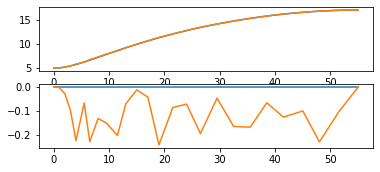

In [141]:
def transform_cartesian_to_frenet(cartesian_state: struct.State, 
                                        reference_path: ReferencePath) -> struct.FrenetState:

    dist, idx = reference_path.kd_tree_.query([cartesian_state.pose_.x_,
                                              cartesian_state.pose_.y_])
    
    # get x- and y-position along reference path
    x_reference  = reference_path.interp_x_[idx, 0]
    y_reference  = reference_path.interp_y_[idx, 0]
    xy_reference = np.array([x_reference, y_reference])

    # get s-coordinate along reference path
    s_reference = reference_path.interp_s_[idx]

    # get heading along reference path
    theta_reference = reference_path.interp_theta_[idx, 0]

    # get curvature along reference path
    kappa_reference = reference_path.interp_kappa_[idx, 0]

    # get first derivative of curvature along reference path
    dkappa_reference = reference_path.interp_dkappa_[idx, 0]

    # calculate difference in heading between trajectory and reference path
    delta_theta = cartesian_state.pose_.theta_ - theta_reference

    # current position of the car
    xy_state = np.array([cartesian_state.pose_.x_, cartesian_state.pose_.y_])

    # calculate distance vector
    d_vector = xy_state - xy_reference

    # calculate tangential vector
    tangential_vector = np.array([np.cos(theta_reference), np.sin(theta_reference)])

    # calculate sign of lateral position
    d_sign = np.sign(np.cross(a=tangential_vector, b=d_vector))

    # calculate quantities in frenèt coordinate system
    frenet_s = s_reference

    frenet_d = d_sign * dist
    
    frenet_s_dot = (cartesian_state.v_ * np.cos(delta_theta)) / (
        1 - kappa_reference * frenet_d
    )

    d_prime = (1 - kappa_reference * frenet_d) * np.tan(delta_theta)
    frenet_d_dot = frenet_s_dot * d_prime

    frenet_s_ddot = (
        np.cos(delta_theta)
        / (1 - kappa_reference * frenet_d)
        * (
            cartesian_state.a_
            - (frenet_s_dot ** 2)
            / np.cos(delta_theta)
            * (
                (1 - kappa_reference * frenet_d)
                * np.tan(delta_theta)
                * (
                    cartesian_state.kappa_
                    * (1 - kappa_reference * frenet_d)
                    / np.cos(delta_theta)
                    - kappa_reference
                )
                - (dkappa_reference * frenet_d + kappa_reference * d_prime)
            )
        )
    )

    d_pprime = -(dkappa_reference * frenet_d + kappa_reference * d_prime) * np.tan(
        delta_theta
    ) + (1 - kappa_reference * frenet_d) / (np.cos(delta_theta) ** 2) * (
        cartesian_state.kappa_
        * (1 - kappa_reference * frenet_d)
        / np.cos(delta_theta)
        - kappa_reference
    )
    frenet_d_ddot = (
        d_pprime * frenet_s_dot ** 2 + d_prime * frenet_s_ddot
    )

    frenet_state = struct.FrenetState(frenet_s, frenet_s_dot, frenet_s_ddot, 
                                      frenet_d, frenet_d_dot, frenet_d_ddot)
    
    return frenet_state

################################################################################################################################

d_trajectory = []
d_dot_trajectory = []

s_trajectory = []
s_dot_trajectory = []

if valid_trajectory == []:
    print("Try generate frenet path again")
else:
    for i in range(len(optimal_trajectory.x_)):
        x = optimal_trajectory.x_[i, 0]
        y = optimal_trajectory.y_[i, 0]
        theta = optimal_trajectory.theta_[i, 0]
        v = optimal_trajectory.v_[i ,0]
        a = optimal_trajectory.a_[i, 0]
        kappa = optimal_trajectory.kappa_[i, 0]
        
        vehicle_pose = struct.Transform(x, y, theta)
        vehicle_state = struct.State(vehicle_pose, v, a, kappa)
        
        frenet_state = transform_cartesian_to_frenet(vehicle_state, ref_path)
        
        d_trajectory.append(frenet_state.d_)
        s_trajectory.append(frenet_state.s_)
        s_dot_trajectory.append(frenet_state.s_dot_)
        
    plt.figure(8)

    plt.subplot(3, 1, 1)
    plt.plot(optimal_trajectory.s_, optimal_trajectory.s_dot_)    
    plt.plot(s_trajectory, s_dot_trajectory)

    plt.subplot(3, 1, 2)
    plt.plot(optimal_trajectory.s_, optimal_trajectory.d_)    
    plt.plot(s_trajectory, d_trajectory)

**Step 10** 假设车辆跟踪误差为 0 的情况下测试局部规划性能

c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in add
c:\ProgramData\anaconda3\envs\kyxz_test\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract


Processing ...
Finish


(-393.4562242800654, 306.5437757199346)

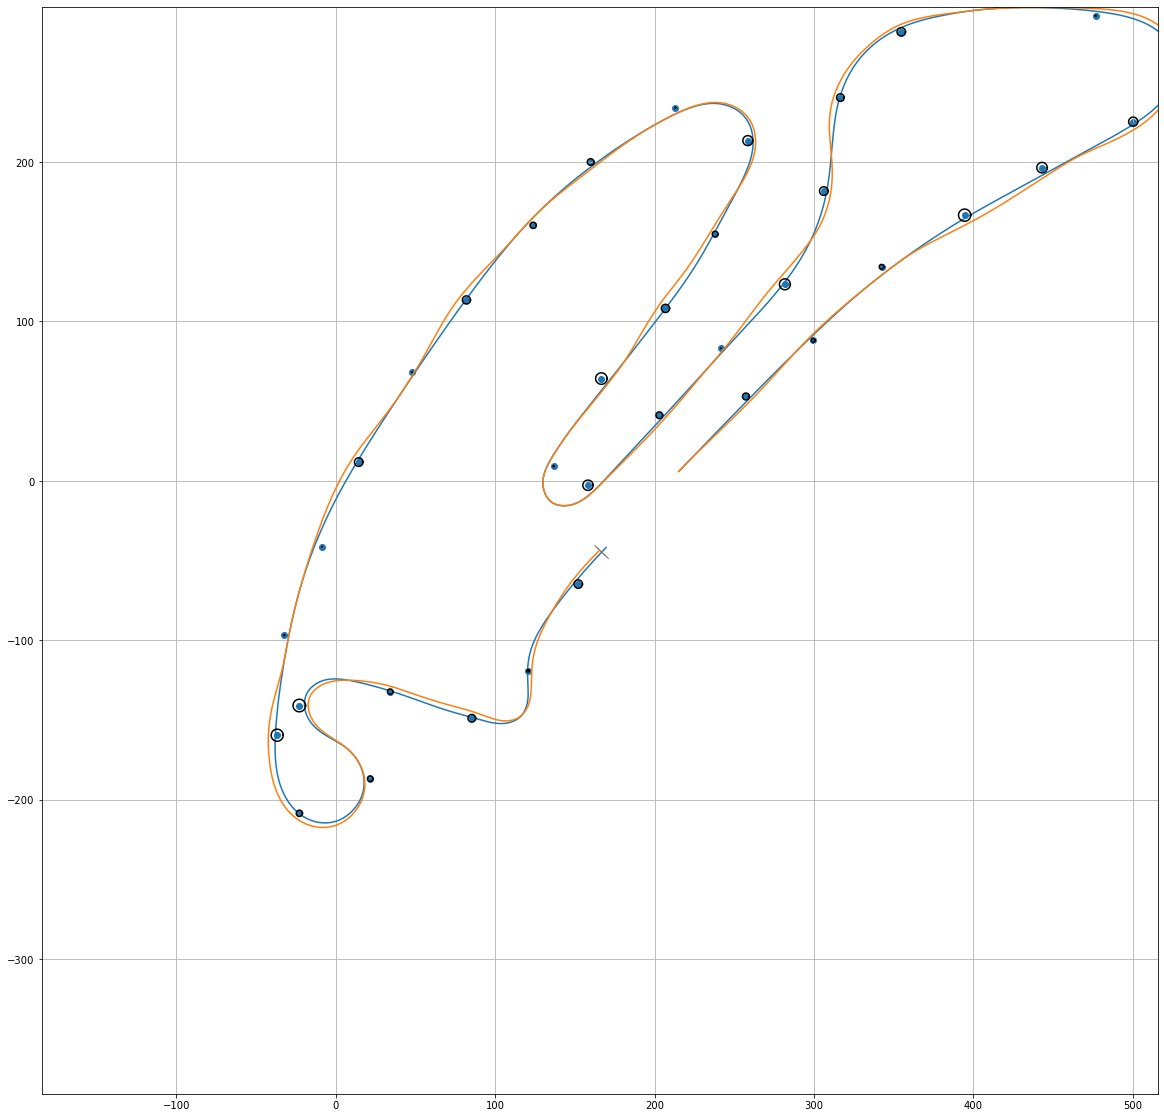

In [142]:
# 生成测试场景
obs_index_gap  = 30
obs_index_list = np.floor(np.arange(obs_index_gap, len(reference_s), obs_index_gap))
obs_x = np.zeros_like(obs_index_list)
obs_y = np.zeros_like(obs_index_list)
obs_r = np.zeros_like(obs_index_list)

obs_list = []

for i in range(len(obs_index_list)):
    index = int(obs_index_list[i])
    obs_x[i] = reference_x[index] + np.random.uniform(-5, 5, 1)
    obs_y[i] = reference_y[index] + np.random.uniform(-5, 5, 1)
    obs_r[i] = np.random.uniform(0, 4, 1)
    
    obs_pose  = struct.Transform(obs_x[i], obs_y[i], 0)
    obs_state = struct.StaticObstacle(obs_pose, obs_r[i])

    obs_list.append(obs_state)
    
# 设置车辆初始状态
initial_x     = reference_x[0, 0]
initial_y     = reference_y[0, 0]
initial_theta = reference_theta[0, 0]

initial_kappa = 0
initial_v     = 0
initial_a     = 0

vehicle_pose  = struct.Transform(initial_x, initial_y, initial_theta)
vehicle_state = struct.State(vehicle_pose, initial_v, initial_a, initial_kappa)

# 设置仿真条件
total_sim_time = 100
sample_time    = 0.1
sim_time       = np.arange(0, total_sim_time, sample_time)

# 初始化记录轨迹的空数组
actual_x_list = []
actual_y_list = []
actual_v_list = []
actual_theta_list = []

# 规划一个轨迹
frenet_state   = transform_cartesian_to_frenet(vehicle_state, ref_path)
planner        = FrenetOptimalPlanner(ref_path)

optimal_trajectory, valid_trajectory, trajectory_list = planner.update_planning(frenet_state, vehicle_geometry, obs_list)

print("Processing ...")
for i in range(len(sim_time)):
    if valid_trajectory != [] and len(optimal_trajectory.s_) > 2:
        index = 1
    else:
        print("No valid path")
        break
    
    if optimal_trajectory.s_[0, 0] >= reference_s[-1, 0]:
        actual_x_list.append(optimal_trajectory.x_[0, 0])
        actual_y_list.append(optimal_trajectory.y_[0, 0])
        actual_v_list.append(optimal_trajectory.v_[0, 0])
        actual_theta_list.append(optimal_trajectory.theta_[0, 0])
        print("Finish")
        break
    
    actual_x_list.append(optimal_trajectory.x_[0, 0])
    actual_y_list.append(optimal_trajectory.y_[0, 0])
    actual_v_list.append(optimal_trajectory.v_[0, 0])
    actual_theta_list.append(optimal_trajectory.theta_[0, 0])
    
    frenet_state = struct.FrenetState(optimal_trajectory.s_[index, 0], 
                                      optimal_trajectory.s_dot_[index, 0], 
                                      optimal_trajectory.s_ddot_[index, 0], 
                                      optimal_trajectory.d_[index, 0], 
                                      optimal_trajectory.d_dot_[index, 0], 
                                      optimal_trajectory.d_ddot_[index, 0])
    
    optimal_trajectory, valid_trajectory, trajectory_list = planner.update_planning(frenet_state, 
                                                                   vehicle_geometry, 
                                                                   obs_list)
    
# 绘图
plt.figure(10, figsize=(20, 20))
plt.plot(reference_x, reference_y)
plt.scatter(obs_x, obs_y)

for i in range(len(obs_index_list)):
    plot_circle(obs_x[i], obs_y[i], obs_r[i], 'black')

for trajectory in trajectory_list:
    plt.plot(trajectory.x_, trajectory.y_, color='gray', linewidth=0.5)

plt.plot(actual_x_list, actual_y_list)
plt.axis('equal')
plt.grid(True)

area = 350
plt.xlim(actual_x_list[-1] - area, actual_x_list[-1] + area)
plt.ylim(actual_y_list[-1] - area, actual_y_list[-1] + area)


**Step 10** 用 `.ini` 文件配置参数，方便调参

In [143]:
import configparser

class Parameters:
    def __init__(self, file_path):
        config = configparser.ConfigParser()
        config.read(file_path)

        # FRENET_OPTIMAL_PLANNER parameters
        self.min_terminal_t_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'min_terminal_t')
        self.max_terminal_t_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'max_terminal_t')
        self.num_terminal_t_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'num_terminal_t')
        self.sample_step_    = config.getfloat('FRENET_OPTIMAL_PLANNER', 'sample_step_')
        self.min_terminal_v_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'min_terminal_v')
        self.max_terminal_v_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'max_terminal_v')
        self.num_terminal_v_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'num_terminal_v')
        self.min_terminal_d_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'min_terminal_d')
        self.max_terminal_d_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'max_terminal_d')
        self.num_terminal_d_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'num_terminal_d')
        
        self.v_limit_        = config.getfloat('FRENET_OPTIMAL_PLANNER', 'v_limit')
        self.a_limit_        = config.getfloat('FRENET_OPTIMAL_PLANNER', 'a_limit')
        self.kappa_limit_    = config.getfloat('FRENET_OPTIMAL_PLANNER', 'kappa_limit')
        
        self.lateral_jerk_coeff_         = config.getfloat('FRENET_OPTIMAL_PLANNER', 'lateral_jerk_coeff')
        self.lateral_time_coeff_         = config.getfloat('FRENET_OPTIMAL_PLANNER', 'lateral_time_coeff')
        self.lateral_deviate_coeff_      = config.getfloat('FRENET_OPTIMAL_PLANNER', 'lateral_deviate_coeff')
        self.longitudinal_jerk_coeff_    = config.getfloat('FRENET_OPTIMAL_PLANNER', 'longitudinal_jerk_coeff')
        self.longitudinal_time_coeff_    = config.getfloat('FRENET_OPTIMAL_PLANNER', 'longitudinal_time_coeff')
        self.longitudinal_deviate_coeff_ = config.getfloat('FRENET_OPTIMAL_PLANNER', 'longitudinal_deviate_coeff')
        self.lateral_cost_coeff_         = config.getfloat('FRENET_OPTIMAL_PLANNER', 'lateral_cost_coeff')
        self.longitudinal_cost_coeff_    = config.getfloat('FRENET_OPTIMAL_PLANNER', 'longitudinal_cost_coeff')

        # LONGITUDINAL_PID parameters
        self.Kp_ = config.getfloat('LONGITUDINAL_PID', 'kp')
        self.Ki_ = config.getfloat('LONGITUDINAL_PID', 'ki')
        self.Kd_ = config.getfloat('LONGITUDINAL_PID', 'kd')

        # LATERAL_STANLEY parameters
        self.K_ = config.getfloat('LATERAL_STANLEY', 'k')

# 创建一个配置解析器对象
parameters = Parameters('./config/params.ini')
parameters.a_limit_

# TODO: 修改 FrenetOptimalPlanner 中算法参数的传递方式

10.0